In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess images from a directory
def load_and_preprocess(path, target_size=(220, 220)):
    images = []
    for filename in os.listdir(path):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(path, filename)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
    return np.array(images)

# Example: Load images from a directory
path = r'/Users/harshdhiman/Documents/Research /Codes/Turbine Blade Damage Detection/ConvAutoencoderWT/Edge_Area'
image_data = load_and_preprocess(path)


In [4]:
image_data.shape

(241, 220, 220, 3)

In [58]:
# Define the autoencoder model
def build_autoencoder(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.InputLayer(input_shape=input_shape))
    #model.add(layers.Rescaling(scale=1./255))
    model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(3,(3,3),activation='relu'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
    #model.add(layers.UpSampling2D((2, 2))) # 224x224x32
    #model.add(layers.Conv2D(3, (3, 3), activation='relu')) # 222 x 222 x 3
    #model.add(layers.Conv2D(3, (3, 3), activation='sigmoid')) # 220 x 220 x 3
    return model

# Build the autoencoder
input_shape = (220, 220, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])  # Mean Squared Error loss for image reconstruction

In [59]:
autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 220, 220, 32)      896       
                                                                 
 batch_normalization_14 (Ba  (None, 220, 220, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 110, 110, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 batch_normalization_15 (Ba  (None, 110, 110, 64)      256       
 tchNormalization)                                               
                                                      

In [60]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [61]:
# Train the autoencoder (using the same data for input and target)
autoencoder.fit(image_data,image_data, epochs=20, batch_size=64, shuffle=True,
                validation_split=0.1,verbose=1,callbacks=[early_stopping_callback])

Epoch 1/20
4/4 [==============================] - 10s 2s/step - loss: 0.0663 - accuracy: 0.2015 - val_loss: 0.0631 - val_accuracy: 0.0048
Epoch 2/20
4/4 [==============================] - 9s 2s/step - loss: 0.0533 - accuracy: 0.0228 - val_loss: 0.0603 - val_accuracy: 0.0057
Epoch 3/20
4/4 [==============================] - 9s 2s/step - loss: 0.0439 - accuracy: 0.0347 - val_loss: 0.0538 - val_accuracy: 0.0079
Epoch 4/20
4/4 [==============================] - 9s 2s/step - loss: 0.0330 - accuracy: 0.0913 - val_loss: 0.0450 - val_accuracy: 0.0397
Epoch 5/20
4/4 [==============================] - 10s 2s/step - loss: 0.0260 - accuracy: 0.2712 - val_loss: 0.0413 - val_accuracy: 0.0583
Epoch 6/20
4/4 [==============================] - 10s 2s/step - loss: 0.0207 - accuracy: 0.2293 - val_loss: 0.0413 - val_accuracy: 0.9716
Epoch 7/20
4/4 [==============================] - 10s 2s/step - loss: 0.0179 - accuracy: 0.8021 - val_loss: 0.0389 - val_accuracy: 0.9848
Epoch 8/20
4/4 [=====================

In [62]:
# Reconstruct images
reconstructed_images = autoencoder.predict(image_data)

8/8 [==============================] - 3s 316ms/step


Visualize pixel distributions of actual and reconstructed image

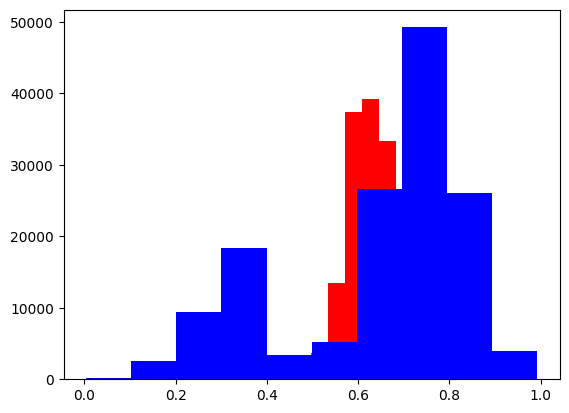

In [102]:
k=np.random.randint(0,image_data.shape[0])
img=reconstructed_images[k].reshape(-1,1)
plt.hist(img,bins=10,color='red')
plt.hist(image_data[k].reshape(-1,1),bins=10,color='blue')
plt.show()